# **House Prices - Advanced Regression Techniques**

### **Competition description**

Chiedi a un acquirente di una casa di descrivere la casa dei suoi sogni e probabilmente non inizierà con l'altezza del soffitto del seminterrato o la vicinanza a una ferrovia est-ovest. Ma il set di dati di questa competizione per parchi giochi dimostra che molto di più influenza le negoziazioni sui prezzi rispetto al numero di camere da letto o a una staccionata bianca.

Con 79 variabili esplicative che descrivono (quasi) ogni aspetto delle case residenziali ad Ames, Iowa, questa competizione ti sfida a prevedere il prezzo finale di ogni casa.

### **Datasets info**

I datasets (*trainset.csv* e *testset.csv*) sono disponibili all'interno della folder "*./ML_House_prices/house-prices-advanced-regression-techniques*". Oltre ai datasets sono presenti anche i file:
* *sample_submission.csv*: una presentazione di riferimento da una regressione lineare su anno e mese di vendita, metratura del lotto e numero di camere da letto
* *data_description.txt*: descrizione complet di ogni colonna 


### **1 Caricamento del dataset**

#### *1.1 Loading libraries*

In [5541]:

import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import patches
from sklearn.impute import KNNImputer
from manager import manager
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import statsmodels.api as sm
from sklearn.covariance import EllipticEnvelope
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector, chi2
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

%pip install fast_ml --upgrade

from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features

Note: you may need to restart the kernel to use updated packages.


#### *1.2 Trainset & Testset loading*

In [5542]:
trainset = pd.read_csv("./house-prices-advanced-regression-techniques/train.csv")
lenght_trainset = trainset.shape
print("Trainset dimension: ")
print(trainset.shape)
trainset.head(10)
testset = pd.read_csv("./house-prices-advanced-regression-techniques/test.csv")
print("Testeset dimension: ")
print(testset.shape)


Trainset dimension: 
(1460, 81)
Testeset dimension: 
(1459, 80)


#### *1.3 Check differences between datasets*

Il numero di colonne del testset è minore rispetto a quello del trainset. L'idea è quindi quella di vedere quali colonne non sono rispettivamente presenti nei datasets.

In [5543]:
#check if every feature in trainset is also present in testset and viceversa
notInTestset = []
notInTrainset = []
for x in trainset.columns:
    if not testset.columns.__contains__(x):
        notInTestset.append(x)
print(f"Columns in trainset but not in testset: {notInTestset} \n")
for x in testset.columns:
    if not trainset.columns.__contains__(x):
        notInTrainset.append(x)
print(f"Columns in testset but not in trainset: {notInTrainset} \n")
        


Columns in trainset but not in testset: ['SalePrice'] 

Columns in testset but not in trainset: [] 



In [5544]:
#info of trainset
trainset_info = trainset.info()
print(trainset_info)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5545]:
#info of testset
testset_info = testset.info()
print(testset_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC


La prima feature eliminabile è "*Id*" essendo inutile ai fini dell'analisi dei dati.

In [5546]:
#delete feature "ID" from trainset beacause it is not relevant
if "Id" in trainset.columns:
    trainset.drop(["Id"], axis="columns", inplace=True)

#delete feature "ID" from testset and save it
if "Id" in testset.columns:
    idList = testset['Id'].tolist()
    testset.drop(['Id'], axis="columns", inplace=True)
print(trainset.shape)
    

(1460, 80)


Divisione del trainset in modo tale da separare la colonna di cui effettuare la predizione dal resto delle features, in modo da studiare in dati in maniera più semplice.

In [5547]:
target = trainset.iloc[:, len(trainset.columns)-1]
target.head(10)
trainset.drop(target.name, axis="columns", inplace=True)
trainset.head(10)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


### **2 Data exploration**


#### *2.1 Cleaning data*

L'idea è eliminare tutte le righe che hanno una percentuale di *NaN* maggiore del *50%*. 
In questo modo non vengono utilizzate righe che hanno poco valore per il *Data analysis*

In [5548]:
nanPercInARow = []
rowsToDelete = 0
for index, row in trainset.iterrows():
    nanPercInARow.append(trainset.loc[[index]].isna().sum().sum() / len(trainset.columns))
    if nanPercInARow[index] > 0.5:
        rowsToDelete+=1
        trainset.drop(index, axis="rows", inplace=True)

print("Number of rows with a Nan percentual more than 50%:")
print(rowsToDelete)


Number of rows with a Nan percentual more than 50%:
0


Nessuna riga viene eliminata, di conseguenza sono tutte utili al fine dell'analisi dei dati.

Divisione del trainset:
* *Numerical Trainset* = Trainset contenente unicamente le features che hanno un valore numerico
* *Categorical Trainset* = Trainset contenente unicamente le features che hanno un valore categorico

Lo studio delle features è diviso tra questi due porzioni del Trainset, il quale verrà "riassemblato" una volta completate le due analisi.

In [5549]:
#parsing trainset
print(trainset.shape)
trainset_num = trainset.select_dtypes(include=[np.number])
trainset_cat = trainset.select_dtypes(exclude=[np.number])



#parsing testset
testset_num = testset.select_dtypes(include=[np.number])
testset_cat = testset.select_dtypes(exclude=[np.number])
#print(trainset_cat.columns)
#print(trainset_num.columns)
print(trainset_num.shape)
print(trainset_cat.shape)

(1460, 79)
(1460, 36)
(1460, 43)


#### *2.2 Numerical Trainset analysis*

##### *2.2.1 Quasi-constant features*

Il primo passo è quello di eliminare le feature con una varianza quasi costante.

L'implementazione sfrutta la librerio *sklearn.feature_selection.VarianceThreshold*. Essa viene utilizzata per determinare una threshold massima di varianza.
Nel nostro caso vengono eliminate tutte le variabili che hanno una varianza massima del **5%**.

In [5550]:

qconstant_filter = VarianceThreshold(threshold=0.05)
qconstant_filter.fit(trainset_num)
qconstant_columns = [column for column in trainset_num.columns
                    if column not in trainset_num.columns[qconstant_filter.get_support()]]

print("Quasi-costant features: ")
print(qconstant_columns)



for column in qconstant_columns:
    
    trainset_num.drop(column, axis="columns", inplace=True)
    testset_num.drop(column,axis="columns", inplace=True)  


print("New numerical Trainset shape: " + str(trainset_num.shape))



Quasi-costant features: 
['KitchenAbvGr']
New numerical Trainset shape: (1460, 35)


Abbiamo 35 variabili numeriche significative nel Numerical Trainset.

##### *2.2.2 NaN management*

Solitamente per bypassare il problema dei **nan** si utilizza una pratica chiamata **imputing**. Attraverso questa operazione si sostituiscono i **nan** con dei valori estratti dallo stesso dataset che si vuole modellare. La tecnica di *imputing* più semplice e più diffusa consiste nel sostituire ai **nan** della *feature* i-esima la media della stessa *feature*.

Più genericamente distinguiamo queste due grandi famiglie di **metodi di imputing**:
* *Imputing univariato*: si estraggono delle statistiche dalla feature che si vuole "ricostruire" e si sostituiscono ai nan dei valori provenienti da queste statistiche. Un esempio di questa applicazione è proprio il *mean imputing* discusso qualche riga sopra. In questa famiglia di metodi di imputing non si bada in alcun modo all'interazione e all'influenza delle altre feature.
* *Multivariate Imputing*: n questo caso i nan della feature i-esima vengono ricavati mediante il supporto delle altre feature. Quindi, ad esempio, è possibile rimpiazzare un nan di una feature con un valore predetto da un albero addestrato su delle osservazioni complete e prive di nan.

Nel nostro caso è stato utilizzato il secondo metodo, in quanto produce valori con bias minore, a discapito della varianza, rispetto al primo.

Tipo di imputation utilizzata :
* **kNN ( k-Nearest Neighbor) Imputation**: L'idea della kNN  imputation è identificare "k" samples nel dataset che sono simili o vicini nello spazio. Quindi utilizziamo questi "k" samples per stimare il valore dei dati mancanti. I valori mancanti di ciascun sample vengono imputati utilizzando il valore medio dei vicini "k" trovati nel set di dati.

In [5551]:
#nan management
trainset_num.isna().sum()
#use knn
imputer = KNNImputer(n_neighbors=1, weights="uniform")
trainset_num_imputed = trainset_num
testset_num_imputed = testset_num
trainset_num_imputed = pd.DataFrame(imputer.fit_transform(trainset_num))
trainset_num_imputed.columns = trainset_num.columns
testset_num_imputed = pd.DataFrame(imputer.fit_transform(testset_num))
testset_num_imputed.columns = testset_num.columns



In [5552]:
#trainset_num.isna().sum()
print(trainset_num_imputed.shape)
print(testset_num_imputed.shape)

(1460, 35)
(1459, 35)


##### *2.2.3 Correlation*

La correlazione è una misura statistica che esprime la relazione lineare tra due variabili (che quindi cambiano insieme a una velocità costante) ed è molto usata per descrivere semplici relazioni senza dover parlare di causa ed effetto.

La correlazione viene descritta mediante un valore che non è dotato di un'unità di misura specifica, chiamato coefficiente di correlazione, compreso tra -1 e +1 e denotato da **r**.
* Più *r* si avvicina a zero, più la correlazione lineare è debole.
* Un valore *r** positivo è indice di una correlazione positiva, in cui i valori delle due variabili tendono ad aumentare in parallelo.
* Un valore **r** negativo è indice di una correlazione negativa, in cui il valore di una variabile tende ad aumentare quando l'altra diminuisce.


In [5553]:
trainset_num_conc =pd.concat([trainset_num_imputed, target], axis="columns")
correlation_matrix = trainset_num_conc.corr()

plt.figure(figsize=(15, 16), dpi=160)
#sns.heatmap(correlation_matrix, cmap="bwr")
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "6pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "10pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '80px'),
                        ('font-size', '10pt')])
]

correlation_matrix.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '40px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.00,-0.35,-0.14,0.03,-0.06,0.03,0.04,0.03,-0.07,-0.07,-0.14,-0.24,-0.25,0.31,0.05,0.07,0.00,-0.00,0.13,0.18,-0.02,0.04,-0.05,0.07,-0.04,-0.10,-0.01,-0.01,-0.01,-0.04,-0.03,0.01,-0.01,-0.01,-0.02,-0.08
LotFrontage,-0.35,1.00,0.38,0.20,-0.04,0.09,0.05,0.16,0.22,0.08,0.09,0.35,0.41,0.09,0.03,0.38,0.09,0.03,0.19,0.06,0.26,0.32,0.24,0.05,0.25,0.31,0.10,0.12,0.04,0.06,0.06,0.14,0.01,0.02,0.02,0.32
LotArea,-0.14,0.38,1.00,0.11,-0.01,0.01,0.01,0.10,0.21,0.11,-0.00,0.26,0.30,0.05,0.00,0.26,0.16,0.05,0.13,0.01,0.12,0.19,0.27,-0.01,0.15,0.18,0.17,0.08,-0.02,0.02,0.04,0.08,0.04,0.00,-0.01,0.26
OverallQual,0.03,0.20,0.11,1.00,-0.09,0.57,0.55,0.41,0.24,-0.06,0.31,0.54,0.48,0.30,-0.03,0.59,0.11,-0.04,0.55,0.27,0.10,0.43,0.40,0.54,0.60,0.56,0.24,0.31,-0.11,0.03,0.06,0.07,-0.03,0.07,-0.03,0.79
OverallCond,-0.06,-0.04,-0.01,-0.09,1.00,-0.38,0.07,-0.13,-0.05,0.04,-0.14,-0.17,-0.14,0.03,0.03,-0.08,-0.05,0.12,-0.19,-0.06,0.01,-0.06,-0.02,-0.30,-0.19,-0.15,-0.00,-0.03,0.07,0.03,0.05,-0.00,0.07,-0.00,0.04,-0.08
YearBuilt,0.03,0.09,0.01,0.57,-0.38,1.00,0.59,0.31,0.25,-0.05,0.15,0.39,0.28,0.01,-0.18,0.20,0.19,-0.04,0.47,0.24,-0.07,0.10,0.15,0.80,0.54,0.48,0.22,0.19,-0.39,0.03,-0.05,0.00,-0.03,0.01,-0.01,0.52
YearRemodAdd,0.04,0.05,0.01,0.55,0.07,0.59,1.00,0.18,0.13,-0.07,0.18,0.29,0.24,0.14,-0.06,0.29,0.12,-0.01,0.44,0.18,-0.04,0.19,0.11,0.61,0.42,0.37,0.21,0.23,-0.19,0.05,-0.04,0.01,-0.01,0.02,0.04,0.51
MasVnrArea,0.03,0.16,0.10,0.41,-0.13,0.31,0.18,1.00,0.27,-0.07,0.11,0.36,0.34,0.17,-0.07,0.39,0.09,0.03,0.27,0.20,0.10,0.28,0.25,0.26,0.36,0.37,0.16,0.13,-0.11,0.02,0.06,0.01,-0.03,-0.00,-0.01,0.48
BsmtFinSF1,-0.07,0.22,0.21,0.24,-0.05,0.25,0.13,0.27,1.00,-0.05,-0.50,0.52,0.45,-0.14,-0.06,0.21,0.65,0.07,0.06,0.00,-0.11,0.04,0.26,0.16,0.22,0.30,0.20,0.11,-0.10,0.03,0.06,0.14,0.00,-0.02,0.01,0.39
BsmtFinSF2,-0.07,0.08,0.11,-0.06,0.04,-0.05,-0.07,-0.07,-0.05,1.00,-0.21,0.10,0.10,-0.10,0.01,-0.01,0.16,0.07,-0.08,-0.03,-0.02,-0.04,0.05,-0.07,-0.04,-0.02,0.07,0.00,0.04,-0.03,0.09,0.04,0.00,-0.02,0.03,-0.01


<Figure size 2400x2560 with 0 Axes>

Vediamo la correlazione tra le features:
* se | r | > 0.80 :       strong correlation
* se 0.5 < | r | < 0.80 : moderate correlation
* se 0.20 < | r | < 0.5 : weak correlation
* se | r | < 0.2 :        very weak or null correlation

Nel nostro caso vediamo la correlazione tra le featuers e la label "*SalePrice*". Scarteremo tutte le features che hanno un valore di correlazione inferiore **| r | <0.2**

In [5554]:
target_correlation = trainset_num_conc.corr()[target.name][:-1]
target_correlation

MSSubClass      -0.084284
LotFrontage      0.316983
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.475611
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.492040
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
Name: SalePrice, dtype: float64

In [5555]:
#find features with a very weak correlations 
very_weak_corr = target_correlation[abs(target_correlation)<0.25].sort_values(ascending=False)
#print something
very_weak_corr_names = target_correlation[abs(target_correlation)<0.25].index.tolist()
#print(very_weak_corr_names)

#find features with a weak correlations
weak_corr = target_correlation[(abs(target_correlation)>=0.25) & (abs(target_correlation)<0.50)].sort_values(ascending=False)
#print something
weak_corr_list = target_correlation[(abs(target_correlation)>=0.25) & (abs(target_correlation)<0.50)].index.tolist()

#find features with a moderate correlations
moderate_corr = target_correlation[(abs(target_correlation)>=0.50) & (abs(target_correlation)<0.75)].sort_values(ascending=False)
moderate_corr_list = target_correlation[(abs(target_correlation)>=0.50) & (abs(target_correlation)<0.75)].index.tolist()
#print(moderate_corr)

#find features with a strong correlations
strong_corr = target_correlation[(abs(target_correlation)>=0.75)].sort_values(ascending=False)
strong_corr_list = target_correlation[(abs(target_correlation)>=0.75)].index.tolist()
#print(strong_corr)



In [5556]:
#trainset and testset with only correlated feature
trainset_num_corr = trainset_num_conc.loc[:, strong_corr_list + moderate_corr_list + weak_corr_list + [target.name]]
testset_num_corr = testset_num_imputed.loc[:, strong_corr_list + moderate_corr_list + weak_corr_list]

print(trainset_num_corr.shape)
print(testset_num_corr.shape)

trainset_num_corr.head(10)


(1460, 21)
(1459, 20)


,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,...,LotArea,MasVnrArea,BsmtFinSF1,2ndFlrSF,HalfBath,Fireplaces,GarageYrBlt,WoodDeckSF,OpenPorchSF,SalePrice
0,7.0,2003.0,2003.0,856.0,856.0,1710.0,2.0,8.0,2.0,548.0,...,8450.0,196.0,706.0,854.0,1.0,0.0,2003.0,0.0,61.0,208500
1,6.0,1976.0,1976.0,1262.0,1262.0,1262.0,2.0,6.0,2.0,460.0,...,9600.0,0.0,978.0,0.0,0.0,1.0,1976.0,298.0,0.0,181500
2,7.0,2001.0,2002.0,920.0,920.0,1786.0,2.0,6.0,2.0,608.0,...,11250.0,162.0,486.0,866.0,1.0,1.0,2001.0,0.0,42.0,223500
3,7.0,1915.0,1970.0,756.0,961.0,1717.0,1.0,7.0,3.0,642.0,...,9550.0,0.0,216.0,756.0,0.0,1.0,1998.0,0.0,35.0,140000
4,8.0,2000.0,2000.0,1145.0,1145.0,2198.0,2.0,9.0,3.0,836.0,...,14260.0,350.0,655.0,1053.0,1.0,1.0,2000.0,192.0,84.0,250000
5,5.0,1993.0,1995.0,796.0,796.0,1362.0,1.0,5.0,2.0,480.0,...,14115.0,0.0,732.0,566.0,1.0,0.0,1993.0,40.0,30.0,143000
6,8.0,2004.0,2005.0,1686.0,1694.0,1694.0,2.0,7.0,2.0,636.0,...,10084.0,186.0,1369.0,0.0,0.0,1.0,2004.0,255.0,57.0,307000
7,7.0,1973.0,1973.0,1107.0,1107.0,2090.0,2.0,7.0,2.0,484.0,...,10382.0,240.0,859.0,983.0,1.0,2.0,1973.0,235.0,204.0,200000
8,7.0,1931.0,1950.0,952.0,1022.0,1774.0,2.0,8.0,2.0,468.0,...,6120.0,0.0,0.0,752.0,0.0,2.0,1931.0,90.0,0.0,129900
9,5.0,1939.0,1950.0,991.0,1077.0,1077.0,1.0,5.0,1.0,205.0,...,7420.0,0.0,851.0,0.0,0.0,2.0,1939.0,0.0,4.0,118000


##### *2.2.4 Outlier dectection*

plot delle feature. check normality by plotting a frequency distribution, also called a histogram, of the data and visually comparing it to a normal distribution

In [5557]:
def detect_outliers_zscore(data):
    thres = 3
    outliers = []
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code

print("{:<30}{:<20}".format("Feature", "Percentage of ouliers"))
percentageOutliers = []
for col in trainset_num_corr.columns[:-1]:   
    sample_outliers = detect_outliers_zscore(trainset_num_corr.iloc[:][col])
    percentageOutliers.append((len(sample_outliers)/len(trainset_num_corr))*100)
    print("{:<30}{:<20}".format(col, str((len(sample_outliers)/len(trainset_num_corr))*100)) + " %")
    
print("Max Percentage: " + str(max(percentageOutliers))+ " %")
    
    

Feature                       Percentage of ouliers
OverallQual                   0.136986301369863    %
YearBuilt                     0.410958904109589    %
YearRemodAdd                  0.0                  %
TotalBsmtSF                   0.684931506849315    %
1stFlrSF                      0.821917808219178    %
GrLivArea                     1.095890410958904    %
FullBath                      0.0                  %
TotRmsAbvGrd                  0.821917808219178    %
GarageCars                    0.0                  %
GarageArea                    0.4794520547945206   %
LotFrontage                   1.095890410958904    %
LotArea                       0.8904109589041096   %
MasVnrArea                    2.191780821917808    %
BsmtFinSF1                    0.410958904109589    %
2ndFlrSF                      0.273972602739726    %
HalfBath                      0.821917808219178    %
Fireplaces                    0.3424657534246575   %
GarageYrBlt                   0.068493150684931

valori accettabili perchè gli outliers di una gaussiana sono circa il 2.5%

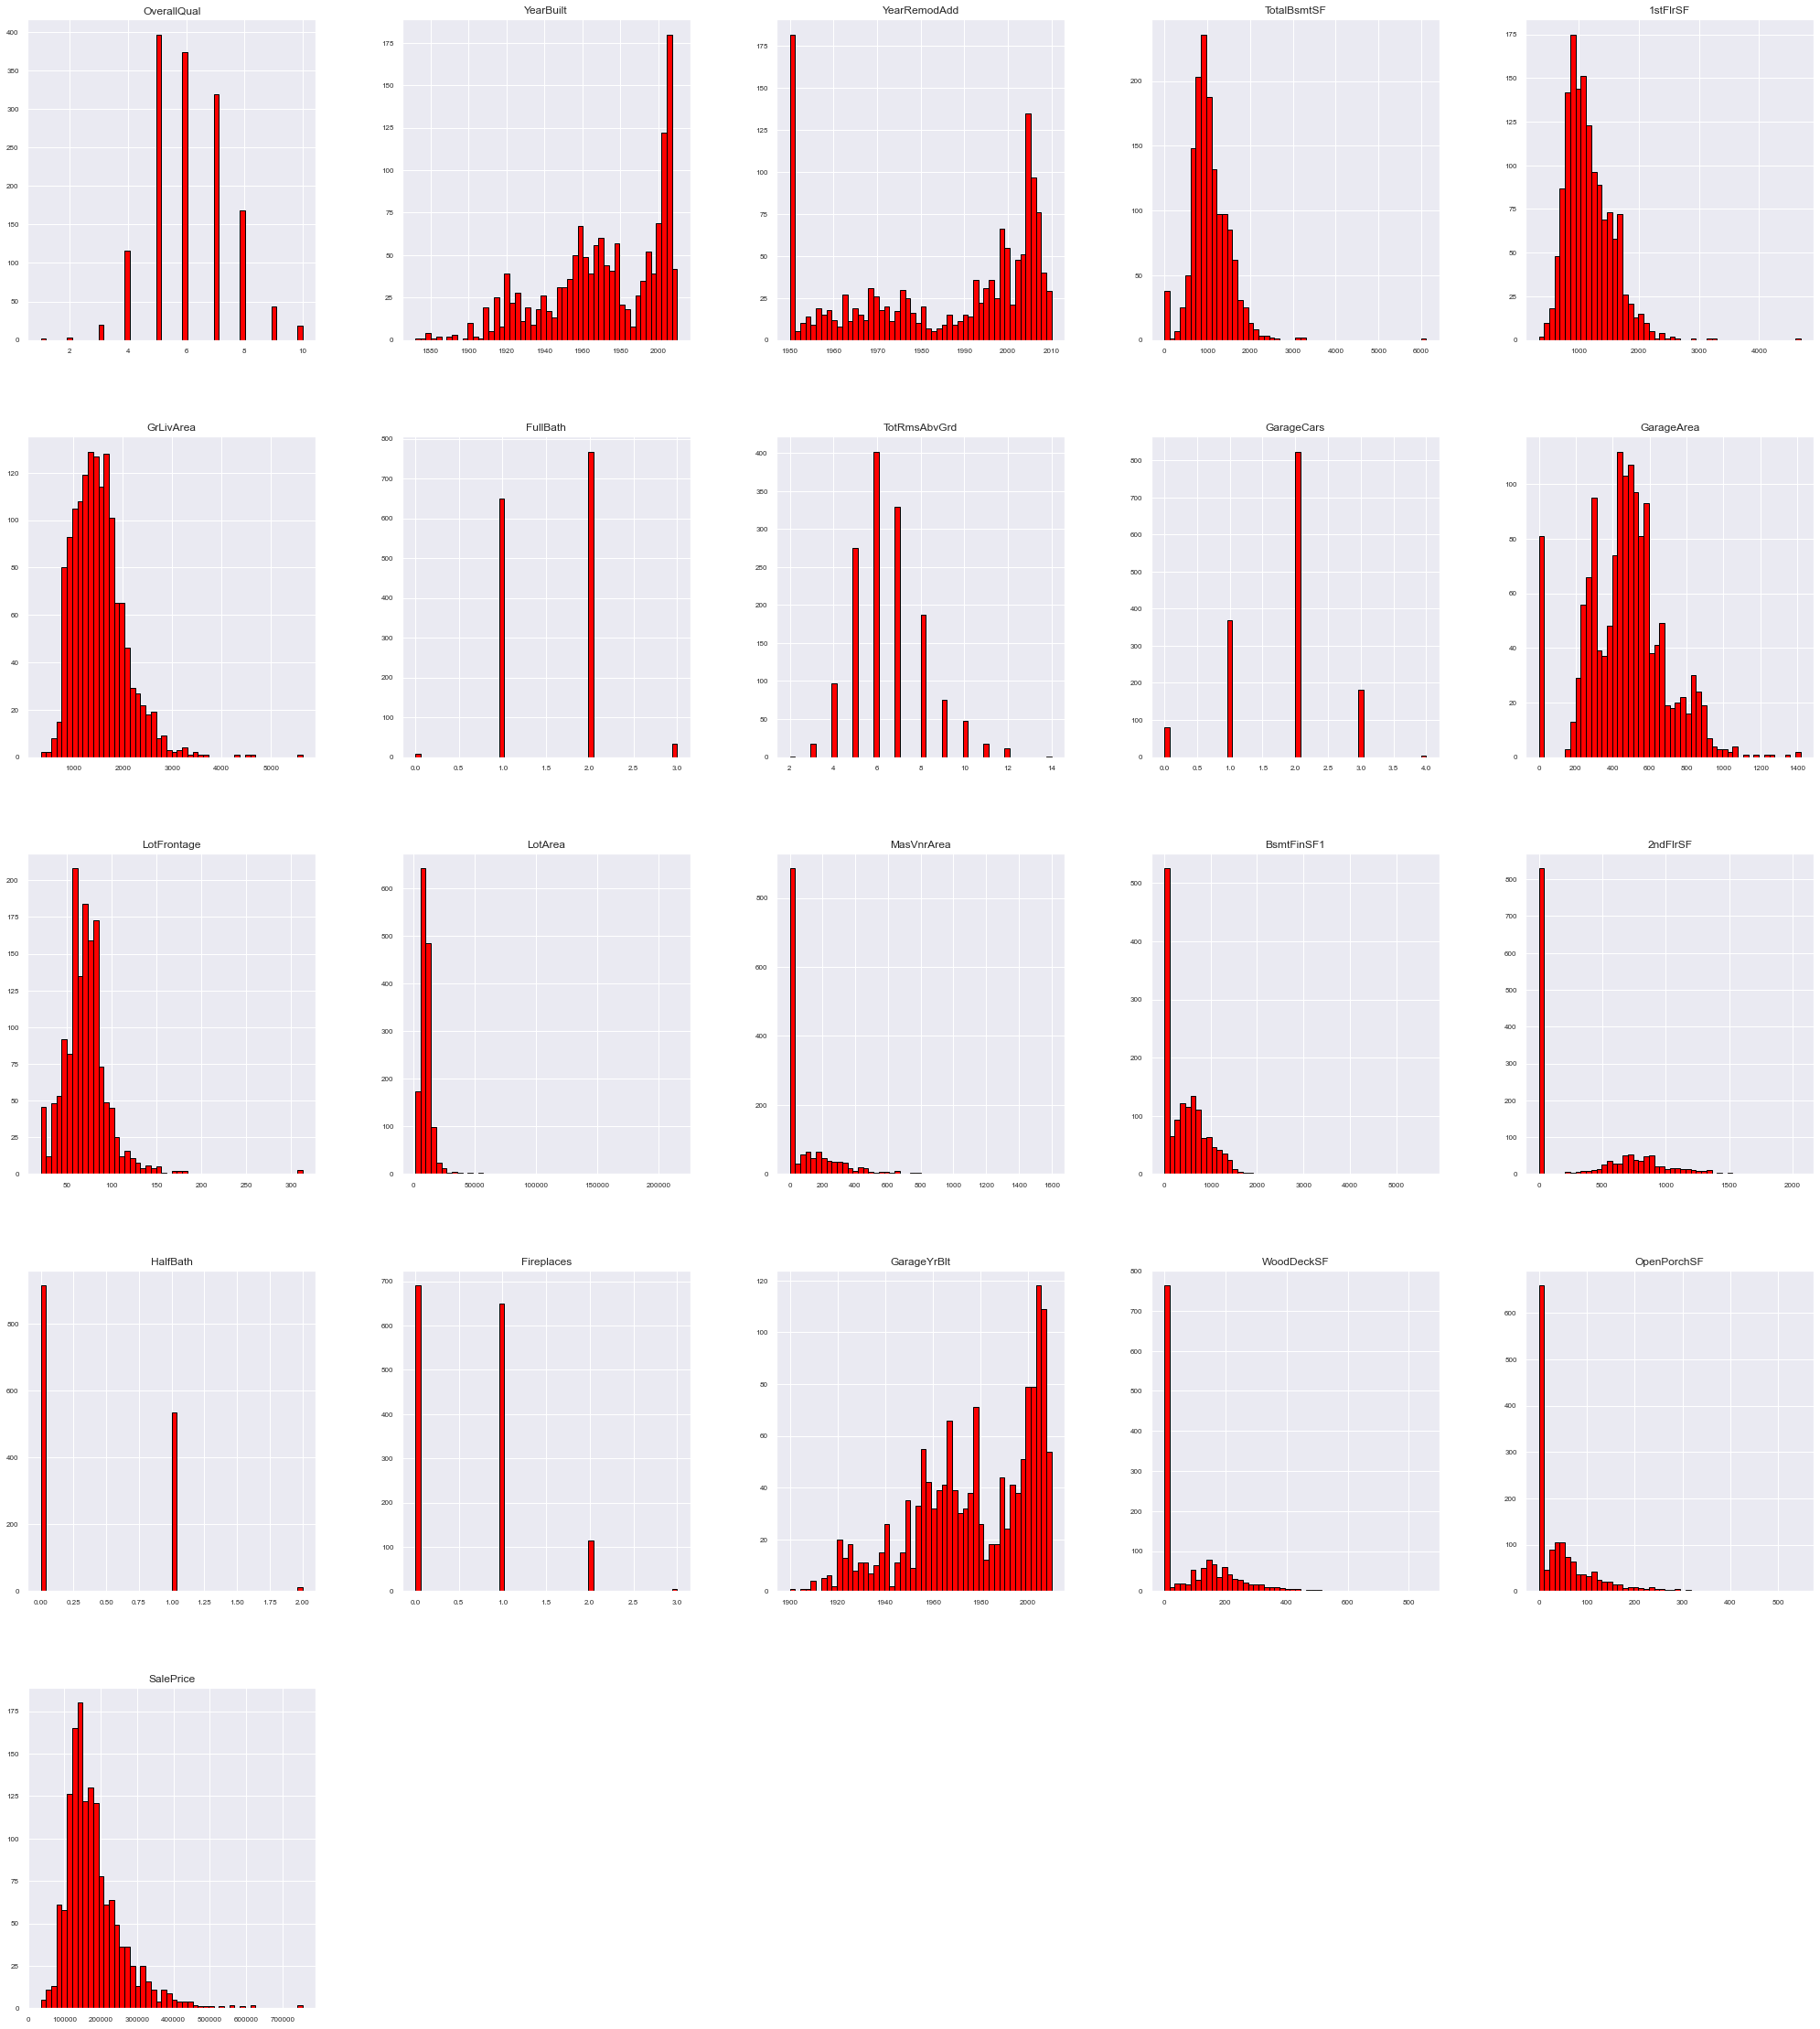

In [5558]:
plot = trainset_num_corr.hist(figsize=(35,40), bins=50, color="red", edgecolor="black", xlabelsize=8, ylabelsize=8)
    

Dai grafici si può notare la maggior parte delle feature ha una distribuzione simil-normale. Grazie a questo motivo possiamo considerare attendibile il metodo *z-score*.

Si potrebbe utilizzare anche un altro metodo univariato:
* **IQR** 

In [5559]:

def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers# Driver code


print("Outliers from IQR method: ", sample_outliers)


print("{:<30}{:<20}".format("Feature", "Percentage of ouliers"))
percentageOutliers = []
for col in trainset_num_corr.columns[:-1]:   
    sample_outliers = detect_outliers_iqr(trainset_num_corr.iloc[:][col])
    percentageOutliers.append((len(sample_outliers)/len(trainset_num_corr))*100)
    print("{:<30}{:<20}".format(col, str((len(sample_outliers)/len(trainset_num_corr))*100)) + " %")
    
print("Max Percentage: " + str(max(percentageOutliers))+ " %")

Outliers from IQR method:  [258.0, 260.0, 250.0, 523.0, 285.0, 406.0, 502.0, 274.0, 312.0, 267.0, 265.0, 288.0, 341.0, 247.0, 291.0, 312.0, 418.0, 364.0, 252.0, 282.0, 319.0, 263.0, 304.0, 287.0, 292.0, 547.0, 262.0]
Feature                       Percentage of ouliers
OverallQual                   0.136986301369863    %
YearBuilt                     0.4794520547945206   %
YearRemodAdd                  0.0                  %
TotalBsmtSF                   4.178082191780822    %
1stFlrSF                      1.36986301369863     %
GrLivArea                     2.1232876712328768   %
FullBath                      0.0                  %
TotRmsAbvGrd                  2.054794520547945    %
GarageCars                    0.3424657534246575   %
GarageArea                    1.4383561643835616   %
LotFrontage                   7.739726027397261    %
LotArea                       4.726027397260274    %
MasVnrArea                    6.6438356164383565   %
BsmtFinSF1                    0.4794520547

studio delle Categorical features

43


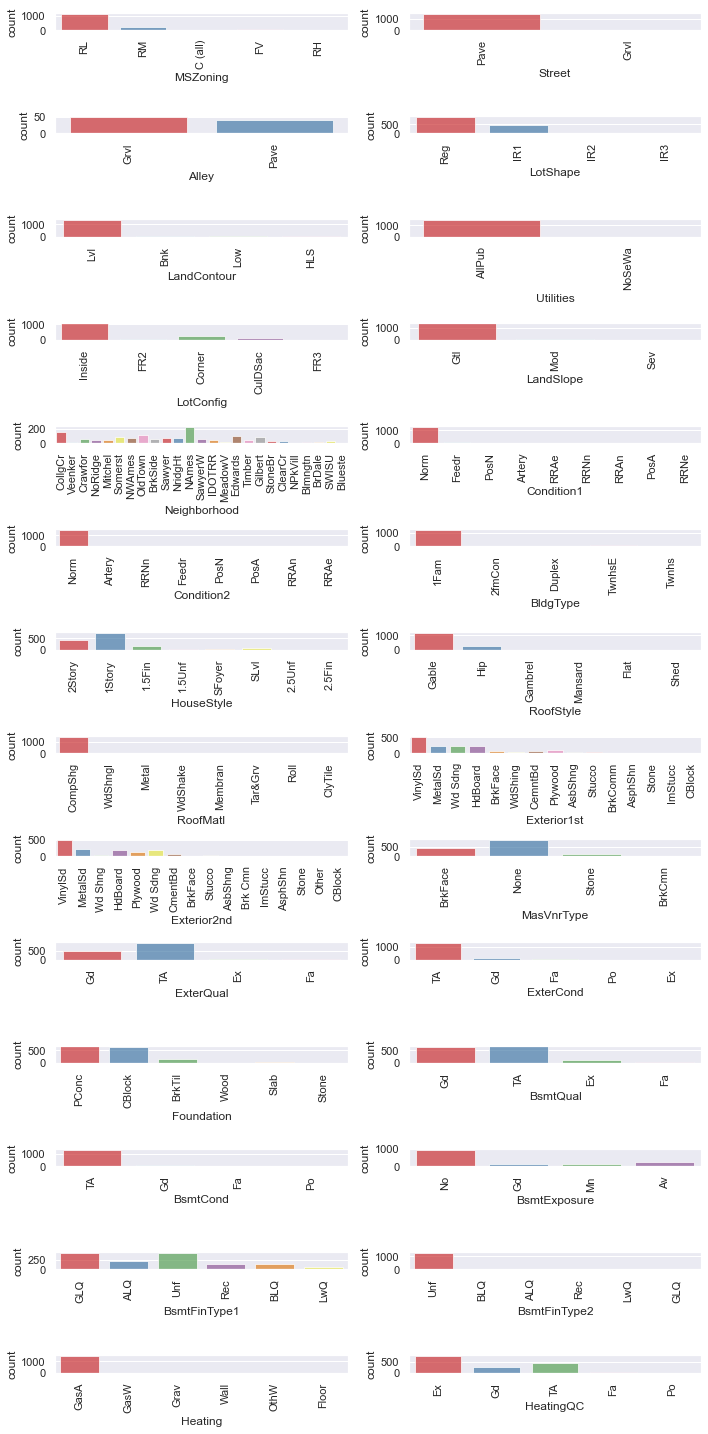

In [5560]:
#check di ogni colonna, elimino le colonne che hanno tutti i valori uguali
print(len(trainset_cat.columns))
fig, axes = plt.subplots(round(len(trainset_cat.columns)/3 ), 2, figsize=(10, 20))


for i, axis in enumerate(fig.axes):
        if i < len(trainset_cat.columns)-1:
            
            axis.set_xticklabels(axis.xaxis.get_majorticklabels(), rotation=90)
            sns.countplot(x=trainset_cat.columns[i], alpha=0.7, data=trainset_cat, ax=axis, palette="Set1")
            
fig.tight_layout()
            

eliminazione di feature costanti

In [5561]:
constant_features = get_constant_features(trainset_cat, threshold=0.95, dropna=False)
print(constant_features)
quasi_constant_features_list = constant_features.query("Desc=='Quasi Constant'")['Var'].to_list()
print(quasi_constant_features_list)
print(trainset_cat.columns)
print(trainset_cat.shape)
trainset_cat_filt = trainset_cat.drop(quasi_constant_features_list, axis="columns", inplace=False)
testset_cat_filt = testset_cat.drop(quasi_constant_features_list, axis="columns", inplace=False)
print(trainset_cat.shape)
    

             Desc          Var    Value       Perc
0  Quasi Constant    Utilities   AllPub  99.931507
1  Quasi Constant       Street     Pave  99.589041
2  Quasi Constant       PoolQC      NaN  99.520548
3  Quasi Constant   Condition2     Norm  98.972603
4  Quasi Constant     RoofMatl  CompShg  98.219178
5  Quasi Constant      Heating     GasA  97.808219
6  Quasi Constant  MiscFeature      NaN  96.301370
['Utilities', 'Street', 'PoolQC', 'Condition2', 'RoofMatl', 'Heating', 'MiscFeature']
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType',

Gestione dei nan in trainset_cat

In [5562]:
print(len(trainset_cat_filt.columns))
columnsWithHighPercOfNan = []
for col in trainset_cat_filt.columns:
    if trainset_cat_filt[col].isna().sum() >= len(trainset_cat)*0.40:
        columnsWithHighPercOfNan.append(col)

print("Columns with high percentage of NaN to drop: ")
print(columnsWithHighPercOfNan)

trainset_cat_filt.drop(columnsWithHighPercOfNan, axis="columns", inplace=True)
testset_cat_filt.drop(columnsWithHighPercOfNan, axis="columns", inplace=True)

trainset_cat_filt.columns

36
Columns with high percentage of NaN to drop: 
['Alley', 'FireplaceQu', 'Fence']


Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

riempimento dei nan

In [5563]:
for col in testset_cat_filt.columns:
    
    if trainset_cat_filt[col].isna().sum() > 0:
        print(col + " number of nan= " + str(trainset_cat_filt[col].isna().sum()))
        categ_fill_null = {col: trainset_cat_filt[col].mode().iloc[0]}
        trainset_cat_filt = trainset_cat_filt.fillna(value=categ_fill_null)        
    
       




MasVnrType number of nan= 8
BsmtQual number of nan= 37
BsmtCond number of nan= 37
BsmtExposure number of nan= 38
BsmtFinType1 number of nan= 37
BsmtFinType2 number of nan= 38
Electrical number of nan= 1
GarageType number of nan= 81
GarageFinish number of nan= 81
GarageQual number of nan= 81
GarageCond number of nan= 81


data exploration manuale del trainset_cat

In [5564]:
print(trainset_cat_filt.columns)

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


encoding categorical features

In [5565]:
#encoding trainset
featureToEncode = []
lastTrainsetIndex = len(trainset_cat_filt)
df_cat = pd.concat([trainset_cat_filt, testset_cat_filt], axis="rows")
#print(lastTrainsetIndex)
#print(trainset_cat.shape)
#print(testset_cat.shape)
#print(trainset_cat_filt.head)
for col in df_cat.columns:
    featureToEncode.append(col)
    #print(str(col)+ "\n")
    #print(trainset_cat[col].unique())
    #trainset_cat[col] = trainset_cat[col].astype['category']

le = LabelEncoder()
for col in df_cat.select_dtypes(include='O').columns:
    #df_cat[col]=le.fit_transform(df_cat[col])
    df_cat_dummies = pd.get_dummies(df_cat)
#encoder = OneHotEncoder(drop="first")

#df_cat_encoded = encoder.fit_transform(df_cat)
#df_cat = pd.DataFrame(df_cat_encoded.toarray(), columns=encoder.get_feature_names(), index=df_cat.index)

#split del df_cat in trainset_cat e testset_cat dopo l'encoding

trainset_cat_encoded = df_cat_dummies.iloc[:lastTrainsetIndex , :]
testset_cat_encoded = df_cat_dummies.iloc[lastTrainsetIndex: , :]

#concatenazione di trainset_num e trainset_cat dopo l'encoding
print(trainset_cat_encoded.head(10))

#trainset = pd.concat([trainset_num, trainset_cat], axis="columns")


#concatenazione di trainset_num e trainset_cat dopo l'encoding

#testset = pd.concat([testset_num, testset_cat], axis="columns")


print(trainset_cat_encoded.shape)
print(testset_cat_encoded.shape)






   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   
2                 0            0            0            1            0   
3                 0            0            0            1            0   
4                 0            0            0            1            0   
5                 0            0            0            1            0   
6                 0            0            0            1            0   
7                 0            0            0            1            0   
8                 0            0            0            0            1   
9                 0            0            0            1            0   

   LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  \
0             0             0             0             1                0   
1             0   

PreProcessamento: feature engeneering

In [5566]:
new_trainset = pd.concat([trainset_num_corr, trainset_cat_encoded], axis="columns")
new_testset = pd.concat([testset_num_corr, testset_cat_encoded], axis="columns")

print(new_trainset.shape)
print(new_testset.shape)



(1460, 229)
(1459, 228)


In [5567]:
# Convert Year of construction to the Age of the house since the construction
lastYear = max(new_trainset["YearBuilt"].max(), new_trainset["YearRemodAdd"].max())
#print(lastYear)

new_trainset["AgeSinceConst"] = (lastYear - new_trainset["YearBuilt"])
new_testset["AgeSinceConst"] = (lastYear - new_testset["YearBuilt"])

# Drop "YearBuilt"
new_trainset.drop(["YearBuilt"], axis=1, inplace=True)
new_testset.drop(["YearBuilt"], axis=1, inplace=True)

# Convert Year of remodeling to the Age of the house since the remodeling
new_trainset["AgeSinceRemod"] = (lastYear - new_trainset["YearRemodAdd"])
new_testset["AgeSinceRemod"] = (lastYear - new_testset["YearRemodAdd"])

# Drop "YearRemodAdd"
new_trainset.drop(["YearRemodAdd"], axis=1, inplace=True)
new_testset.drop(["YearRemodAdd"], axis=1, inplace=True)
new_trainset.shape

(1460, 229)

log trasformation

In [5568]:
# Log transformation of the target variable "SalePrice"
new_trainset["SalePriceLog"] = np.log(new_trainset.SalePrice)

# Drop the original SalePrice
new_trainset.drop(["SalePrice"], axis=1, inplace=True)

split dati e scaling

In [5569]:
bins = np.linspace(0, len(target), 150)
X = new_trainset[[i for i in list(
    new_trainset.columns) if i != "SalePriceLog"]]
print(X.shape)

# Target (y)

y = new_trainset.loc[:, "SalePriceLog"]
    
y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
#print(X.head(10))
print(X_train.head(4))


(1460, 228)
      OverallQual  TotalBsmtSF  1stFlrSF  GrLivArea  FullBath  TotRmsAbvGrd  \
1015          8.0        810.0     810.0     1665.0       2.0           6.0   
1220          5.0        912.0     912.0      912.0       1.0           5.0   
465           7.0       1375.0    1414.0     1414.0       2.0           6.0   
176           6.0       1151.0    1164.0     2060.0       2.0           8.0   

      GarageCars  GarageArea  LotFrontage  LotArea  ...  SaleType_Oth  \
1015         2.0       528.0         70.0   8400.0  ...             0   
1220         1.0       288.0         66.0   7800.0  ...             0   
465          2.0       398.0         43.0   3072.0  ...             0   
176          2.0       521.0         97.0  10029.0  ...             0   

      SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
1015            1                      0                      0   
1220            1                      1                      0   
465             1        

In [5570]:
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
# The same standardization is applied for df_test_new
new_testset = std_scale.transform(new_testset)

# Convert X, y and test data into dataframe
X_train = pd.DataFrame(X_train, columns=X.columns)
print(X_train.head(4))
X_test = pd.DataFrame(X_test, columns=X.columns)
new_testset = pd.DataFrame(new_testset, columns=X.columns)

y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index().drop("index", axis=1)

y_test = pd.DataFrame(y_test)
y_test = y_test.reset_index().drop("index", axis=1)

   OverallQual  TotalBsmtSF  1stFlrSF  GrLivArea  FullBath  TotRmsAbvGrd  \
0     1.401611    -0.566656 -0.917276   0.327276  0.809554     -0.287949   
1    -0.765752    -0.321618 -0.644240  -1.132495 -1.005339     -0.907332   
2     0.679156     0.790660  0.699527  -0.159314  0.809554     -0.287949   
3    -0.043298     0.252539  0.030321   1.093026  0.809554      0.950816   

   GarageCars  GarageArea  LotFrontage   LotArea  ...  SaleType_Oth  \
0    0.344096    0.289080    -0.003735 -0.217854  ...     -0.050746   
1   -1.000065   -0.838424    -0.166827 -0.286787  ...     -0.050746   
2    0.344096   -0.321651    -1.104606 -0.829984  ...     -0.050746   
3    0.344096    0.256194     1.097135 -0.030699  ...     -0.050746   

   SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0     0.396966              -0.269339              -0.050746   
1     0.396966               3.712790              -0.050746   
2     0.396966              -0.269339              -0.050746   
3     0

selected feature

In [5571]:
Selected_Features = []


def backward_regression(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression 

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_in -- pvalue threshold of features to keep
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling 
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")
    
    
backward_regression(X_train, y_train)


worst_feature : HouseStyle_1.5Unf, 0.9896851375765403 
worst_feature : Electrical_FuseF, 0.9857077381333946 
worst_feature : Exterior2nd_HdBoard, 0.9825224132510793 
worst_feature : Exterior1st_WdShing, 0.9777884982445799 
worst_feature : BldgType_2fmCon, 0.9777458470952742 
worst_feature : Electrical_FuseA, 0.9623034973751823 
worst_feature : GarageType_CarPort, 0.9581541606016756 
worst_feature : Functional_Mod, 0.9562773752498261 
worst_feature : Neighborhood_Blmngtn, 0.9503692105455253 
worst_feature : Neighborhood_Gilbert, 0.9709791350029111 
worst_feature : GarageType_Detchd, 0.9481185868686159 
worst_feature : Exterior1st_VinylSd, 0.9388121797923705 
worst_feature : RoofStyle_Flat, 0.9396197020412914 
worst_feature : RoofStyle_Hip, 0.9925699436765587 
worst_feature : Exterior2nd_VinylSd, 0.924733012789635 
worst_feature : HouseStyle_1Story, 0.9304940119016964 
worst_feature : HeatingQC_Gd, 0.921794497793062 
worst_feature : GarageQual_Po, 0.9174290311022332 
worst_feature : Gara

In [5572]:
# Keep the selected features only
X_train = X_train.loc[:, Selected_Features[0]]
X_test = X_test.loc[:, Selected_Features[0]]
new_testset = new_testset.loc[:, Selected_Features[0]]

X_train.shape

(1168, 63)

In [5573]:
'''
# Here I calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    X_train.values, i) for i in range(X_train.shape[1])]

# VIF results in a table
vif["features"] = X_train.columns
vif.round(1)

# Select features with high VIF
high_vif_list = vif[vif["VIF Factor"] > 10]["features"].tolist()

if len(high_vif_list) == 0:
    # print empty list if low multicolinearity
    print(f"None of the features have a high multicollinearity")
else:
    # print list of features with high multicolinearity
    print(f"List of features with high multicollinearity: {high_vif_list}")
    
    
# Drop features with high multicollinearity from X_train, X_test and df_test_new
X_train.drop(high_vif_list, axis=1, inplace=True)

X_test.drop(high_vif_list, axis=1, inplace=True)

new_testset.drop(high_vif_list, axis=1, inplace=True)
'''




'\n# Here I calculate VIF for each feature\nvif = pd.DataFrame()\nvif["VIF Factor"] = [variance_inflation_factor(\n    X_train.values, i) for i in range(X_train.shape[1])]\n\n# VIF results in a table\nvif["features"] = X_train.columns\nvif.round(1)\n\n# Select features with high VIF\nhigh_vif_list = vif[vif["VIF Factor"] > 10]["features"].tolist()\n\nif len(high_vif_list) == 0:\n    # print empty list if low multicolinearity\n    print(f"None of the features have a high multicollinearity")\nelse:\n    # print list of features with high multicolinearity\n    print(f"List of features with high multicollinearity: {high_vif_list}")\n    \n    \n# Drop features with high multicollinearity from X_train, X_test and df_test_new\nX_train.drop(high_vif_list, axis=1, inplace=True)\n\nX_test.drop(high_vif_list, axis=1, inplace=True)\n\nnew_testset.drop(high_vif_list, axis=1, inplace=True)\n'

In [5574]:
'''
X_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_constant)
lr = model.fit()

# Cook distance
np.set_printoptions(suppress=True)

# Create an instance of influence
influence = lr.get_influence()

# Get Cook's distance for each observation
cooks = influence.cooks_distance

# Result as a dataframe
cook_df = pd.DataFrame({"Cook_Distance": cooks[0], "p_value": cooks[1]})
cook_df.head()


# Remove the influential observation from X_train and y_train
influent_observation = cook_df[cook_df["p_value"] < 0.05].index.tolist()
print(f"Influential observations dropped: {influent_observation}")


# Drop these obsrevations
print(X_train.shape)
X_train = X_train.drop(X_train.index[influent_observation])
y_train = y_train.drop(y_train.index[influent_observation])
print(X_train.shape)
'''
from sklearn.decomposition import PCA

print(X_train.shape)
pca = PCA(n_components=X_train.shape[1]*0.8)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train.shape)




(1168, 63)


ValueError: n_components=50.400000000000006 must be of type int when greater than or equal to 1, was of type=<class 'float'>

model regression

In [ ]:
model_lin = LinearRegression()

model_lasso = Lasso(alpha = 0.001)

model_ridge = Ridge(alpha = 0.001)


Mean scores (Linear Model):
 0.8537674611206194
Standard deviation of scores (Linear Model):
 0.08708642534010401
MSE scores (Linear Model):
 [0.02812281 0.01958723 0.02033619 0.01540736 0.0168586  0.02480957
 0.05545165 0.01281673 0.01003346 0.01902535]
Mean MSE scores: 0.02224489450812333


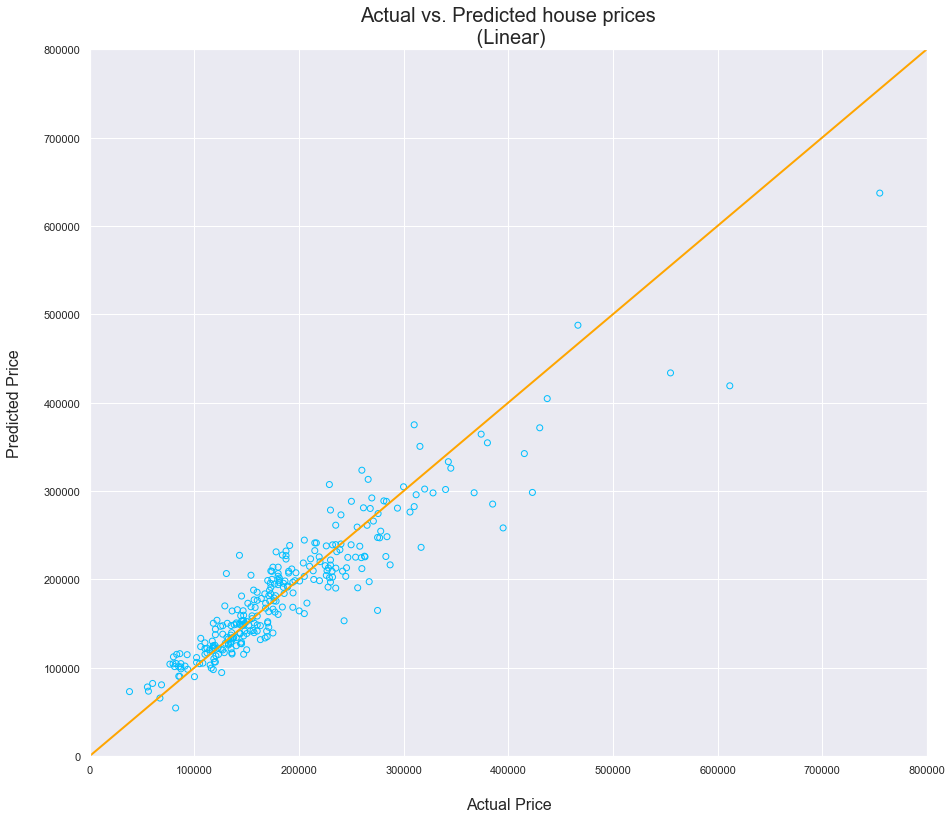

In [ ]:

scores_lin = cross_val_score(model_lin, X_train, y_train,
                 cv=10)

print("Mean scores (Linear Model):\n", np.mean(scores_lin))
print("Standard deviation of scores (Linear Model):\n", np.std(scores_lin))

model_lin.fit(X_train, y_train)
y_pred_lin = model_lin.predict(X_test)
#print_score(y_test, y_pred_lin, "Linear")

scores_linear_mse = -1 * cross_val_score(model_lin, X_train, y_train,
                      cv=10,
                      scoring='neg_mean_squared_error')

print("MSE scores (Linear Model):\n", scores_linear_mse)
print("Mean MSE scores:", scores_linear_mse.mean())

plt.figure()
plt.title("Actual vs. Predicted house prices\n (Linear)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_lin),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "orange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

Mean scores (Lasso Model):
 0.862085776717775
Standard deviation of scores (Lasso Model):
 0.06653424733643712
MSE scores (Lasso Model):
 [0.02785514 0.01925437 0.02043791 0.01500918 0.0166118  0.02487438
 0.0447388  0.01260167 0.00983928 0.01948111]
Mean MSE scores: 0.021070362908390046


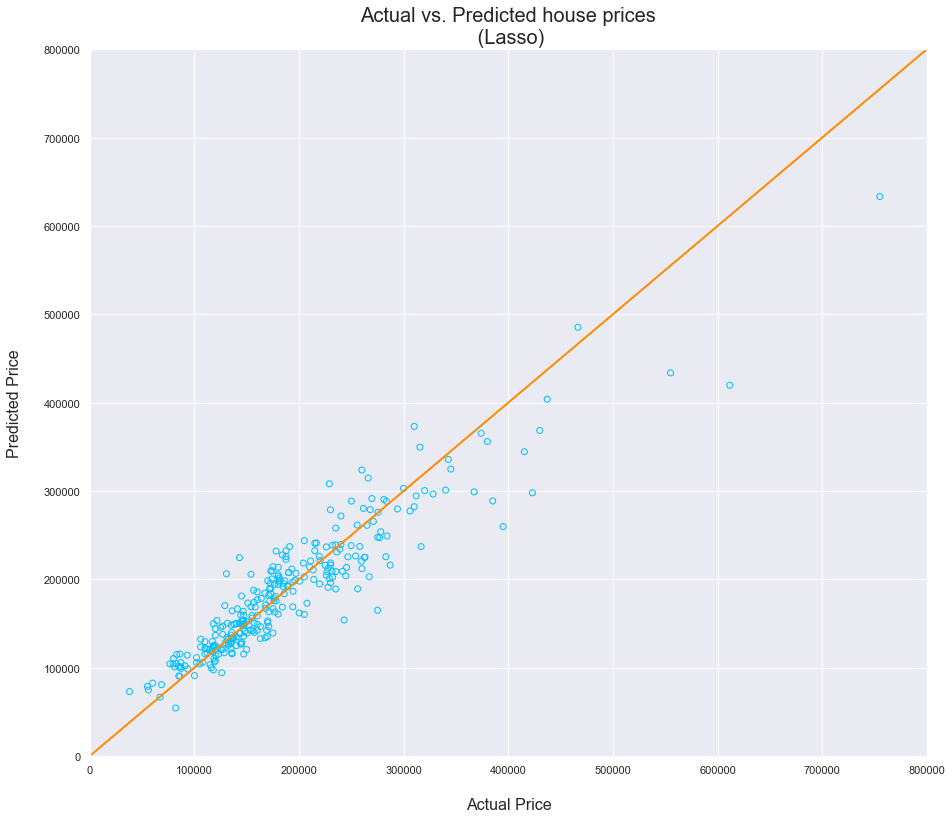

In [ ]:
scores_lasso = cross_val_score(model_lasso, X_train, y_train,
                                cv=10)

print("Mean scores (Lasso Model):\n", np.mean(scores_lasso))
print("Standard deviation of scores (Lasso Model):\n", np.std(scores_lasso))

scores_lasso_mse = -1 * cross_val_score(model_lasso, X_train, y_train,
                                      cv=10,
                                      scoring='neg_mean_squared_error')

print("MSE scores (Lasso Model):\n", scores_lasso_mse)
print("Mean MSE scores:", scores_lasso_mse.mean())


model_lasso.fit(X_train, y_train)
y_pred_lasso = model_lasso.predict(X_test)
#print_score(y_test, y_pred_lasso, "Lasso")


# Save the model results into lists
#model_list.append(model_lasso.__class__.__name__)
#r2_list.append(round(rsqr_score(y_test, y_pred_lasso), 4))
#rmse_list.append(round(rmse_score(y_test, y_pred_lasso), 4))


plt.figure()
plt.title("Actual vs. Predicted house prices\n (Lasso)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_lasso),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()



Mean scores (Ridge Model):
 0.8537678266452463
Standard deviation of scores (Ridge Model):
 0.08708544470255691
MSE scores (Ridge Model):
 [0.0281228  0.01958723 0.02033619 0.01540735 0.01685859 0.02480958
 0.05545115 0.01281673 0.01003345 0.01902536]
Mean MSE scores: 0.022244842789773366


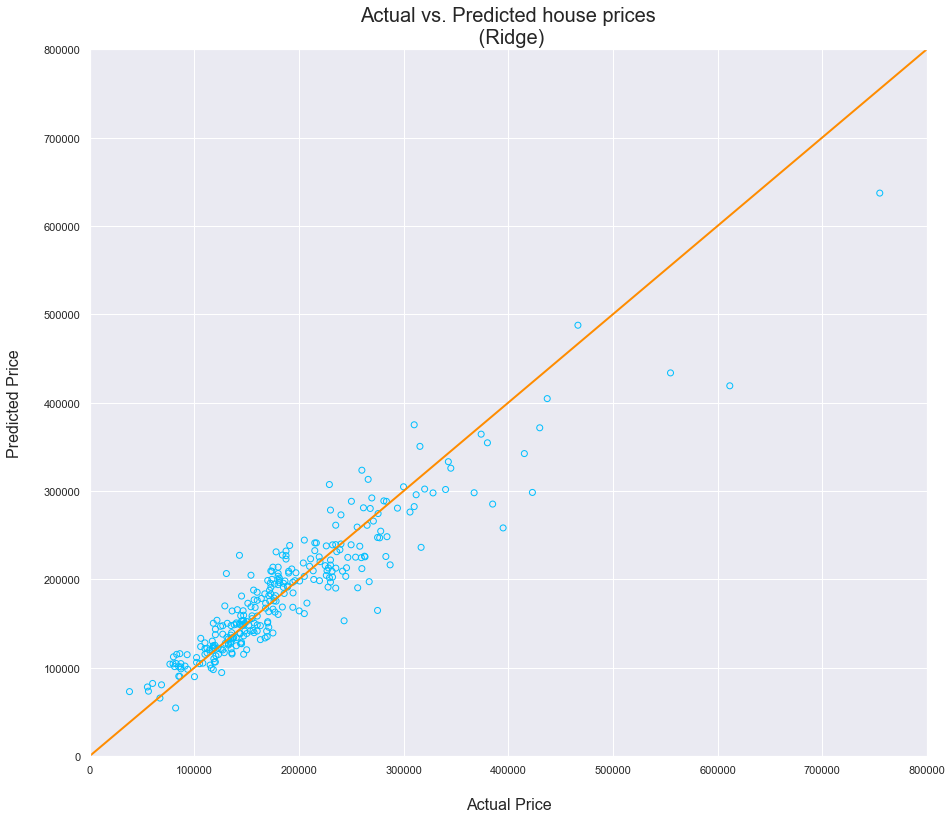

In [ ]:
scores_ridge = cross_val_score(model_ridge, X_train, y_train,
                 cv=10)

print("Mean scores (Ridge Model):\n", np.mean(scores_ridge))
print("Standard deviation of scores (Ridge Model):\n", np.std(scores_ridge))

scores_ridge_mse = -1 * cross_val_score(model_ridge, X_train, y_train,
                      cv=10,
                      scoring='neg_mean_squared_error')

print("MSE scores (Ridge Model):\n", scores_ridge_mse)
print("Mean MSE scores:", scores_ridge_mse.mean())

model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)
#print_score(y_test, y_pred_ridge, "Ridge")

#model_list.append(model_ridge.__class__.__name__)
#r2_list.append(round(rsqr_score(y_test, y_pred_ridge), 4))
#rmse_list.append(round(rmse_score(y_test, y_pred_ridge), 4))

plt.figure()
plt.title("Actual vs. Predicted house prices\n (Ridge)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_ridge),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()